In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
from tensorflow_addons.image import transform as H_transform
import matplotlib.pyplot as plt
import os, datetime

from models.utils import shared_encoder, detector_head, detector_loss, model_metrics, box_nms
from utils.tools import dict_update

In [3]:
default_config = {
        'labels': None,
        'cache_in_memory': False,
        'validation_size': 100,
        'truncate': None,
        'preprocessing': {
            'resize': [240, 320]
        },
        'num_parallel_calls': 10,
        'augmentation': {
            'photometric': {
                'enable': False,
                'primitives': 'all',
                'params': {},
                'random_order': True,
            },
            'homographic': {
                'enable': False,
                'params': {},
                'valid_border_margin': 0,
            },
        },
        'warped_pair': {
            'enable': False,
            'params': {},
            'valid_border_margin': 0,
        },
    }

In [4]:
import yaml
with open('/root/Internship-Valeo/Project/configs/magic-point_coco_train.yaml', 'r') as stream:
    config = yaml.safe_load(stream)

In [5]:
config1 = config
config = dict_update(default_config, config['data'])

In [6]:
default_model_config = {
            'data_format': 'channels_first',
            'kernel_reg': 0.,
            'grid_size': 8,
            'detection_threshold': 0.4,
            'homography_adaptation': {'num': 0},
            'nms': 0,
            'top_k': 0
    }

In [7]:
model_config = dict_update(default_model_config, config1['model'])

In [8]:
from datasets import coco

In [9]:
data = coco.Coco()

In [10]:
files = data._init_dataset(**config)

In [11]:
train_gen = data._get_data(files, 'training', **config)

In [12]:
train_gen

<ParallelMapDataset shapes: {image: (None, None, 1), name: (), keypoints: (None, None), valid_mask: (None, None)}, types: {image: tf.float32, name: tf.string, keypoints: tf.int32, valid_mask: tf.int32}>

In [13]:
val_gen = data._get_data(files, 'validation', **config)

In [14]:
val_gen

<ParallelMapDataset shapes: {image: (None, None, 1), name: (), keypoints: (None, None), valid_mask: (None, None)}, types: {image: tf.float32, name: tf.string, keypoints: tf.int32, valid_mask: tf.int32}>

In [15]:
!pwd

/root/Internship-Valeo/Project


In [53]:
DATA_PATH = '/root/Internship-Valeo/Project/data/COCO'

In [17]:
# from datasets.utils import pipeline
# from datasets.utils.pipeline import parse_primitives
# from datasets.utils import photometric_augmentation as photaug
# from models.homographies import (sample_homography, compute_valid_mask,
#                                             warp_points, filter_points)
from models.utils import box_nms

In [18]:
# config = {
#             'primitives': 'all',
#             'validation_size': 192,
#             'cache_in_memory': False,
#             'truncate': None,
#             'labels': 'magic_point-synth-export/pointstrain2014',
#             'augmentation': {
#                 'photometric': {
#                     'enable': True,
#                     'primitives': [
#                 'random_brightness', 'random_contrast', 'additive_speckle_noise',
#                 'additive_gaussian_noise', 'additive_shade', 'motion_blur' ],
#                     'params': {
#                         'random_brightness': {'max_abs_change': 50},
#                         'random_contrast': {'strength_range': [0.3, 1.5]},
#                         'additive_gaussian_noise': {'stddev_range': [0, 10]},
#                         'additive_speckle_noise': {'prob_range': [0, 0.0035]},
#                         'additive_shade':{
#                             'transparency_range': [-0.5, 0.5],
#                             'kernel_size_range': [100, 150]},
#                         'motion_blur': {'max_kernel_size': 3}},
#                     'random_order': True,
#                 },
#                 'homographic': {
#                     'enable': True,
#                     'params': {
#                         'translation': True,
#                         'rotation': True,
#                         'scaling': True,
#                         'perspective': True,
#                         'scaling_amplitude': 0.2,
#                         'perspective_amplitude_x': 0.2,
#                         'perspective_amplitude_y': 0.2,
#                         'patch_ratio': 0.85,
#                         'max_angle': 1.57,  # 3.14
#                         'allow_artifacts': True,
#                         'valid_border_margin': 3,
#                     },
#                 },
#             }
#     }

In [19]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
# code for photometric augmentation

# primitives_photo = parse_primitives(config['primitives'], photaug.augmentations)

# prim_configs = [config['augmentation']['photometric']['params'].get(p, {}) for p in primitives_photo]

# indices = tf.range(len(primitives_photo))
# if config['augmentation']['photometric']['random_order']:
#     indices = tf.random.shuffle(indices)
# def photo_aug_step(i, image):
#     fn_pairs = [(tf.equal(indices[i], j), lambda p=p, c=c: getattr(photaug, p)(image, **c))
#                 for j, (p, c) in enumerate(zip(primitives_photo, prim_configs))]
#     image = tf.case(fn_pairs)
#     return i + 1, image

In [21]:
# read keypoints
# def _read_points(filename):
#     return np.load(filename)#.astype(np.float32)

In [22]:
# class DataGen(keras.utils.Sequence):
#     def __init__(self, image_path, point_path, #homography_path, warped_image_path, warped_point_path,
#                  is_training, batch_size = model_config['batch_size']):
#         self.__ids = os.listdir(image_path)
#         self.__image_path, self.__point_path = image_path, point_path
        
        
# #         self.__homography_path = homography_path
# #         self.__warped_image_path = warped_image_path
# #         self.__warped_point_path = warped_point_path
        
        
#         self.__batch_size = batch_size
#         self.__is_training = is_training
#         self.on_epoch_end()
        
#     def __load__(self , id_name):
    
#         image_path = os.path.join(self.__image_path , id_name)
#         point_path = os.path.join(self.__point_path , id_name) + '.npy'
    
#         image = cv2.imread(image_path , 0) # 0 specifies GreyScale format
#         image = cv2.resize(image , (320 , 240)) # resizing before inserting to the network
#         image = np.expand_dims(image, axis = 2)
        
#         points = _read_points(point_path)
# #         points = np.round(points).astype(int)
    
#         return image , points
        
#     def __getitem__(self, index):
#         images = []
#         points_maps = []
#         points_list = []
#         homography_list = [] # not returned yet
#         warped_images = []
#         valid_masks = []
#         warped_points_list = []
#         warped_points_maps = []
        
        
#         if (index + 1)*self.__batch_size > len(self.__ids):
#             self.__batch_size = len(self.__ids) - index * self.__batch_size
#         file_batch = self.__ids[index * self.__batch_size : (index + 1) * self.__batch_size]    
        
#         for id_name in file_batch:
#             image, points = self.__load__(id_name)
#             image_shape = tf.shape(image)[:2]

            
# #             homography_file = os.path.join(self.__homography_path, id_name) + '.npy'
# #             homography = _read_points(homography_file)
# #             warped_img_file = os.path.join(self.__warped_image_path, id_name)
# #             warped_image = cv2.imread(warped_img_file, 0)
# #             warped_image = np.expand_dims(warped_image, axis = 2)
# #             warped_point_file = os.path.join(self.__warped_point_path, id_name) + '.npy'
# #             warped_points = _read_points(warped_point_file)
            
    
#             if self.__is_training:
#                 # add photometric_augmentation
#                 _, image = tf.while_loop(lambda i, image: tf.less(i, len(primitives_photo)),
#                                  photo_aug_step, [0, image], parallel_iterations=1)              
                
#                 # add homography
#                 homography = sample_homography(image_shape, config['augmentation']['homographic']['params'])[0]
#                 warped_image = H_transform(image, homography, interpolation='BILINEAR')
#                 valid_mask = compute_valid_mask(image_shape, homography,
#                                          config['augmentation']['homographic']['params']['valid_border_margin'])
#                 warped_points = warp_points(points, homography)
#                 warped_points = filter_points(warped_points, image_shape)
#                 warped_points = np.round(warped_points).astype(int)
#                 warped_kp = tf.minimum(warped_points, image_shape-1)
#                 warped_points_map = tf.scatter_nd(warped_points, tf.ones([tf.shape(warped_points)[0]], 
#                                                                      dtype=tf.int32), image_shape)
                        
#                 homography_list.append(homography)
#                 warped_image = warped_image / 255.0
#                 warped_images.append(warped_image)
#                 valid_masks.append(valid_mask)
#                 warped_points_list.append(warped_points)
#                 warped_points_maps.append(warped_points_map)

#             kp = tf.minimum(points, image_shape-1)
#             points_map = tf.scatter_nd(kp, tf.ones([tf.shape(kp)[0]], dtype=tf.int32), image_shape)
            
#             image = image / 255.0
#             images.append(image)
#             points_maps.append(points_map)
#             points_list.append(points)
            
            
#         images = np.array(images)
#         points_maps = np.expand_dims(points_maps, axis = 3)
#         points_maps = np.array(points_maps)
#         if self.__is_training:
#             warped_images = np.array(warped_images)
#             warped_points_maps = np.expand_dims(warped_points_maps, axis = 3)
#             warped_points_maps = np.array(warped_points_maps)
#             valid_masks = np.array(valid_masks)
#             dummy_loss_target = np.zeros(self.__batch_size)

#             return [warped_images, valid_masks, warped_points_maps], [dummy_loss_target]
        
#         else:
#             return images, points_maps   
           
#     def __len__(self):
#         return int(np.ceil(len(self.__ids) / float(self.__batch_size)))
    
#     def on_epoch_end(self):
#         pass

In [23]:
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(inputs[0], inputs[1]['logits'], model_config = model_config, valid_mask = inputs[2])
        
        if model_config['nms']:
            prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), inputs[1]['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
        metrics = self.metrics_fn(inputs[0], pred, valid_mask = inputs[2])
#         self.add_loss(tf.math.reduce_mean(loss))
        self.add_loss(loss)
        self.add_metric(metrics['precision'], name = 'precision')
        self.add_metric(metrics['recall'], name = 'recall')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

def net(input_shape1, input_shape2, input_shape3):
    images_inputs = Input(shape = input_shape1, name = 'image')
    valid_masks_inputs = Input(shape = input_shape2, name = 'valid_mask')
    warped_points_inputs = Input(shape = input_shape3, name = 'keypoints')
    
    if model_config['data_format'] == 'channels_first':
        images_inputs1 = tf.transpose(images_inputs, [0, 3, 1, 2])
    
    encoder = shared_encoder(shape = (1, 240, 320), model_config = model_config)
    encoder_output = encoder(images_inputs1)
    
    detector = detector_head(shape= (128, 30, 40), model_config = model_config)
    output = detector(encoder_output)
        
    loss_layer = DetectorLossLayer()([warped_points_inputs, output, valid_masks_inputs])
    
    model = keras.models.Model(inputs = [images_inputs, valid_masks_inputs, warped_points_inputs] , 
                               outputs = [loss_layer])
    return model

In [24]:
model = net(input_shape1 = (240, 320, 1), input_shape2 = (240, 320), input_shape3 = (240, 320))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


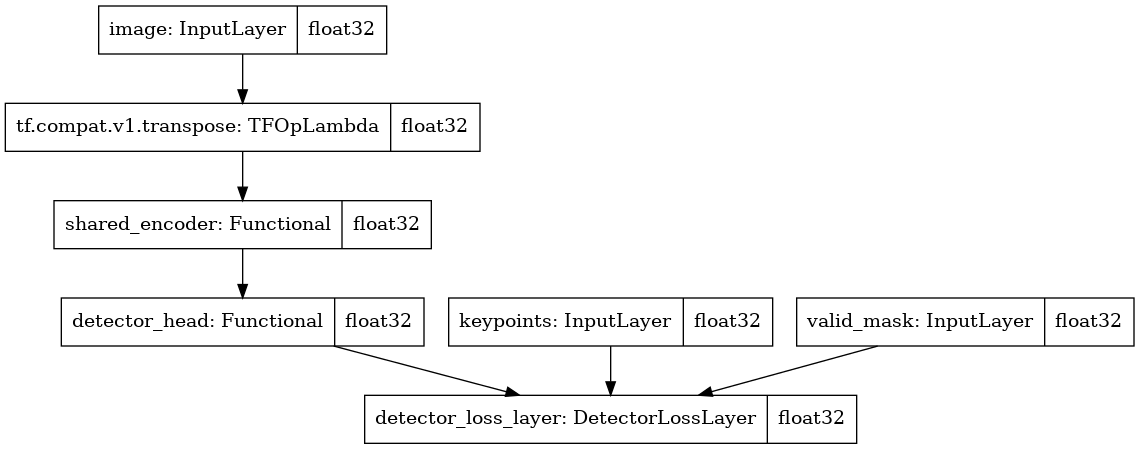

In [25]:
# model.summary()
keras.utils.plot_model(model, to_file="model.png", show_shapes=False, show_dtype=True, show_layer_names=True,
    rankdir="TB", expand_nested=False, dpi=96)

In [26]:
def dummy_loss(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

model.compile(optimizer = keras.optimizers.Adam(learning_rate = model_config['learning_rate']),
              loss = dummy_loss)

In [54]:
# batch_size = model_config['batch_size']

train_image_path = DATA_PATH + '/anntrain2014'
# train_point_path = DATA_PATH + '/pointstrain2014'
# # train_homography_path = DATA_PATH + '/homographies_train'
# # train_warped_image_path = DATA_PATH + '/warptrain2014'
# # train_warped_point_path = DATA_PATH + '/warped_pointstrain2014'
# train_gen = DataGen(train_image_path, train_point_path, #train_homography_path, train_warped_image_path,
# #                     train_warped_point_path, 
#                     batch_size = batch_size, is_training = True)

# val_image_path = DATA_PATH + '/annval2014'
# val_point_path = DATA_PATH + '/pointsval2014'
# # val_homography_path = DATA_PATH + '/homographies_val'
# # val_warped_image_path = DATA_PATH + '/warpval2014'
# # val_warped_point_path = DATA_PATH + '/warped_pointsval2014'
# val_gen = DataGen(val_image_path, val_point_path, #val_homography_path, val_warped_image_path,
# #                   val_warped_point_path, 
#                   batch_size = batch_size, is_training = True)

# train_steps =  len(os.listdir(train_image_path))/batch_size

In [28]:
train_gen = train_gen.repeat()
train_gen = train_gen.batch(model_config['batch_size'])

In [29]:
val_gen = val_gen.take(config['validation_size'])
val_gen = val_gen.batch(model_config['eval_batch_size'])

In [55]:
steps_per_epoch = len(os.listdir(train_image_path))//model_config['batch_size']
epochs = config1['train_iter']//steps_per_epoch
history = model.fit(train_gen , validation_data = val_gen, batch_size = model_config['batch_size'], 
                     steps_per_epoch = steps_per_epoch, epochs=epochs, 
                    callbacks=[tensorboard_callback])

Epoch 1/12
1411/1411 [==============================] - 2430s 2s/step - loss: 1.8934 - precision: 0.0060 - recall: 0.1091 - val_loss: 0.9313 - val_precision: 0.0156 - val_recall: 0.2873
Epoch 2/12
1411/1411 [==============================] - 2364s 2s/step - loss: 0.7981 - precision: 0.0110 - recall: 0.1969 - val_loss: 0.6279 - val_precision: 0.0204 - val_recall: 0.3648
Epoch 3/12
1411/1411 [==============================] - 1166s 826ms/step - loss: 0.6516 - precision: 0.0239 - recall: 0.2243 - val_loss: 0.5203 - val_precision: 0.0607 - val_recall: 0.3938
Epoch 4/12
1411/1411 [==============================] - 740s 525ms/step - loss: 0.6288 - precision: 0.0397 - recall: 0.2259 - val_loss: 0.5085 - val_precision: 0.0742 - val_recall: 0.3996
Epoch 5/12
1411/1411 [==============================] - 688s 487ms/step - loss: 0.6002 - precision: 0.0494 - recall: 0.2390 - val_loss: 0.5057 - val_precision: 0.0724 - val_recall: 0.4047
Epoch 6/12
1411/1411 [==============================] - 661s 46

In [56]:
# model.save('/root/Internship-Valeo/Project/results/checkpoint-magicpoint-coco-040422')

INFO:tensorflow:Assets written to: /root/Internship-Valeo/Project/results/checkpoint-magicpoint-coco-040422/assets


In [ ]:
# model.load_weights('/root/Internship-Valeo/Project/results/checkpoint-magicpoint-coco-050322')

In [ ]:
# x, y = train_gen.__getitem__(0)

In [30]:
y = iter(train_gen)

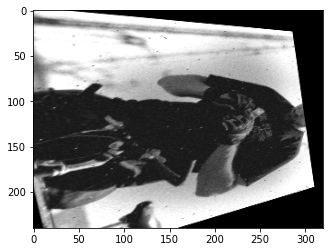

In [42]:
x = y.get_next()
plt.imshow(x['image'][0], cmap = 'gray')

In [43]:
x['image'].shape

TensorShape([32, 240, 320, 1])

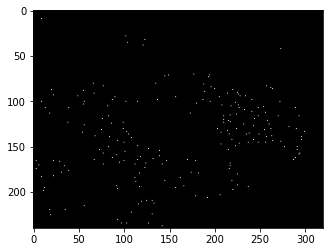

In [44]:
plt.imshow(x['keypoints'][0], cmap = 'gray')

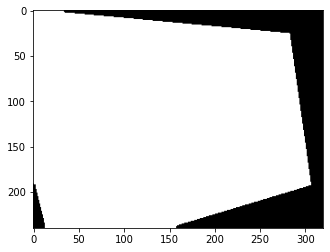

In [45]:
plt.imshow(x['valid_mask'][0], cmap = 'gray')

In [46]:
x['keypoints']

<tf.Tensor: shape=(32, 240, 320), dtype=int32, numpy=
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 

In [37]:
plt.imshow(x[0][31]*255, cmap = 'gray')

KeyError: 0

In [ ]:
plt.imshow(x[1][31], cmap = 'gray')

In [ ]:
plt.imshow(x[2][31],cmap = 'gray')

In [ ]:
y

In [ ]:
x, y = val_gen.__getitem__(1)

In [ ]:
plt.imshow(x[0][0]*255, cmap = 'gray')

In [ ]:
plt.imshow(x[1][0], cmap = 'gray')

In [ ]:
plt.imshow(x[2][0],cmap = 'gray')

In [47]:
result = model(x)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['name'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


In [48]:
tf.math.reduce_mean(result)

<tf.Tensor: shape=(), dtype=float32, numpy=4.1751814>

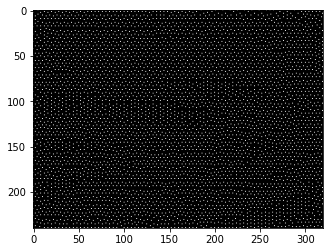

In [49]:
# prob = model.get_layer('tf.compat.v1.squeeze').output

prob = model.get_layer('detector_loss_layer').input[1]['prob']
m = keras.models.Model(inputs = model.input, outputs = prob)

y_pred = m.predict(x)

if model_config['nms']:
    prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), y_pred)
    pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
    
# pred = pred * tf.cast(x['valid_mask'], tf.float32) # multiplied with valid masks

plt.imshow(pred[0], cmap = 'gray')

In [50]:
model_metrics(np.array(tf.cast(x['keypoints'][0], tf.float64)), np.array(pred[0]), np.array(x['valid_mask'][0]))

{'precision': <tf.Tensor: shape=(), dtype=float64, numpy=0.0033505154639175256>,
 'recall': <tf.Tensor: shape=(), dtype=float64, numpy=0.06372549019607843>}